In [24]:
# !sudo pip3 install descartes pysal geopandas

In [3]:
%matplotlib inline
import requests
import json
import geopandas as gpd
import pandas as pd
import ast
import numpy as np

In [4]:
# More files at https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html
shapefiles_zipcodes = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_zcta510_500k.zip"
shapefiles_counties = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_500k.zip"
shapefiles_states = "http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_500k.zip"

## Load GeoDataframe for US States and plot a map

In [5]:
df_states = gpd.read_file(shapefiles_states)

In [6]:
df_states

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,54,01779805,0400000US54,54,WV,West Virginia,00,62265662566,489840834,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
1,17,01779784,0400000US17,17,IL,Illinois,00,143784114293,6211277447,"POLYGON ((-91.512974 40.181062, -91.511073 40...."
2,24,01714934,0400000US24,24,MD,Maryland,00,25150696145,6980371026,"(POLYGON ((-76.05015299999999 37.986905, -76.0..."
3,16,01779783,0400000US16,16,ID,Idaho,00,214048160737,2393355752,"POLYGON ((-117.242675 44.396548, -117.234835 4..."
4,50,01779802,0400000US50,50,VT,Vermont,00,23873457570,1031134839,"POLYGON ((-73.43773999999999 44.045006, -73.43..."
5,09,01779780,0400000US09,09,CT,Connecticut,00,12542619303,1815495323,"(POLYGON ((-72.761427 41.242333, -72.759733 41..."
6,35,00897535,0400000US35,35,NM,New Mexico,00,314191415563,733669653,"POLYGON ((-109.050173 31.480004, -109.049843 3..."
7,34,01779795,0400000US34,34,NJ,New Jersey,00,19049723313,3542963551,"POLYGON ((-75.559102 39.629056, -75.5594459999..."
8,31,01779792,0400000US31,31,NE,Nebraska,00,198957965731,1370523694,"POLYGON ((-104.053418545071 41.1705389679833, ..."
9,42,01779798,0400000US42,42,PA,Pennsylvania,00,115881477379,3397554419,"POLYGON ((-80.519891 40.906661, -80.519091 40...."


In [7]:
# df_states.set_index('STATEFP', inplace=True)

In [8]:
# TODO: Drop states that are 
df_states = df_states[ df_states.NAME!='Alaska' ] #drop Alaska
df_states = df_states[ df_states.NAME!='Hawaii' ] #drop Hawaii
df_states = df_states[ df_states.NAME!='Puerto Rico' ] #drop Puerto Rico
df_states = df_states[ df_states.NAME!='Guam' ] #drop Guam
df_states = df_states[ df_states.NAME!='Commonwealth of the Northern Mariana Islands' ] #drop Mariana Islands
df_states = df_states[ df_states.NAME!='American Samoa' ] #drop American Samoa 
df_states = df_states[ df_states.NAME!='United States Virgin Islands' ] #drop AUnited States Virgin Islands


In [9]:
# Should be 49. The 48 continental, plus DC
assert( len(df_states) == 49 )

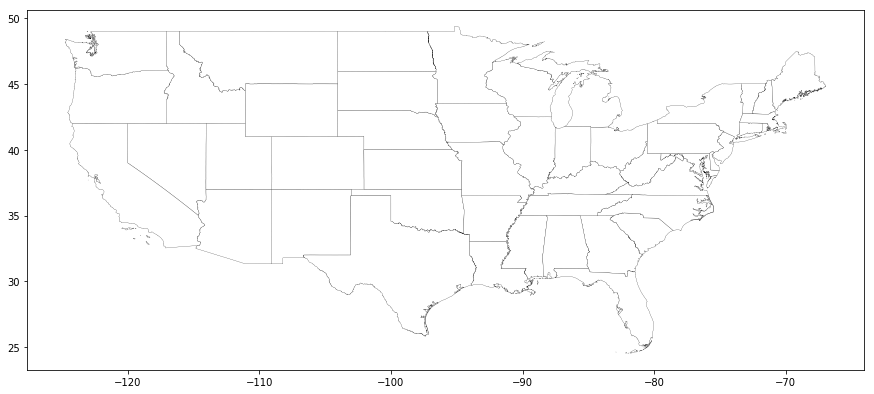

In [10]:
df_states.plot(
    figsize=(15,15), 
    linewidth=0.2, 
    color='white', 
    edgecolor='black'
)

## Load US Counties Datafame and plot a map

In [11]:
df_counties = gpd.read_file(shapefiles_counties)

In [12]:
df_counties

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32...."
5,01,109,00161581,0500000US01109,01109,Pike,06,1740647521,2336975,"POLYGON ((-86.19940799999999 31.807861, -86.19..."
6,01,113,00161583,0500000US01113,01113,Russell,06,1660557977,15661281,"POLYGON ((-85.434721 32.317683, -85.433745 32...."
7,01,117,00161584,0500000US01117,01117,Shelby,06,2034107820,62542790,"POLYGON ((-87.02684599999999 33.246459, -86.98..."
8,02,016,01419965,0500000US02016,02016,Aleutians West,05,11376643262,25184877501,"(POLYGON ((-178.861554 51.575846, -178.857751 ..."
9,04,015,00025445,0500000US04015,04015,Mohave,06,34475503964,387344307,"POLYGON ((-114.753196 36.089513, -114.749534 3..."


In [13]:
len(df_counties)

3233

In [14]:
# There should be 3233 counties looaded
assert( len(df_counties) == 3233 )

In [15]:
# Keep only counties in the lower 48 states + CD
keep_county = df_counties.STATEFP.isin(df_states.STATEFP.values)
df_counties = df_counties[ keep_county ]

In [16]:
# There should be 3108 counties remaining
assert(len(df_counties) == 3108)

In [17]:
# df_counties.set_index(['STATEFP','COUNTYFP'],inplace=True)

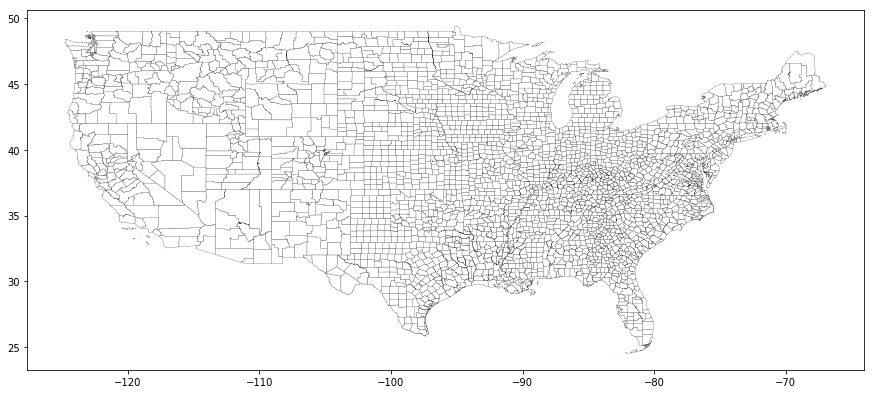

In [18]:
df_counties.plot(
    figsize=(15,15), 
    linewidth=0.2,  
    color='white', 
    edgecolor='black'
)

## Getting Census Data

You need to get an API Key from http://api.census.gov/data/key_signup.html.

In [19]:
class Census:
    def __init__(self, key):
        self.key = key

    def get(self, fields, geo, year=2010, dataset='sf1'):
        fields = [','.join(fields)]
        template_url = 'https://api.census.gov/data/{year}/{dataset}?key={key}&get='
        base_url = template_url.format(year=str(year), dataset=dataset, key=self.key)
        query = fields
        for item in geo:
            query.append(item)
        add_url = '&'.join(query)
        url = base_url + add_url
        response = requests.get(url)
        return ast.literal_eval(response.text) 

api_key = '627d4107b57d4576f2120d2b87b59c7440e5d2af'
census = Census(api_key)

## Plot a Choropleth with Population of US States

In [20]:
# Fetch state population data from US Census
census_response = census.get(['P0010001'], ['for=state:*'])
# Manipulate the result from the US Census API and convert the result to a dataframe
df_state_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP'])
df_state_population['Population'] = pd.to_numeric(df_state_population['Population'])
df_state_population['LogPopulation'] = np.log10(df_state_population['Population'])
# df_state_population

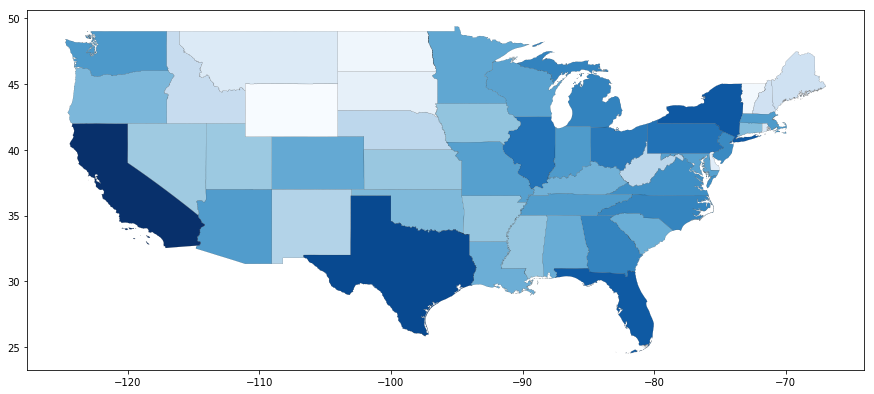

In [21]:
# Augment the df_states geodataframe with population information
states_choropleth = pd.merge(df_states, df_state_population, on='STATEFP')

states_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues',  # select color scheme from http://matplotlib.org/users/colormaps.html
    linewidth=0.1, 
    edgecolor='black'
)

## Plot a Choropleth with Population of US Counties

In [22]:
# Query the US Census API for the population of each county
census_response = census.get(['P0010001'], ['in=state:*', 'for=county:*'])
# Manipulate the API response and put the results in a dataframe
df_county_population = pd.DataFrame(census_response[1:], columns = ['Population', 'STATEFP', 'COUNTYFP'])
df_county_population['Population'] = pd.to_numeric(df_county_population['Population'])
df_county_population['LogPopulation'] = np.log10(df_county_population['Population'])
# df_county_population

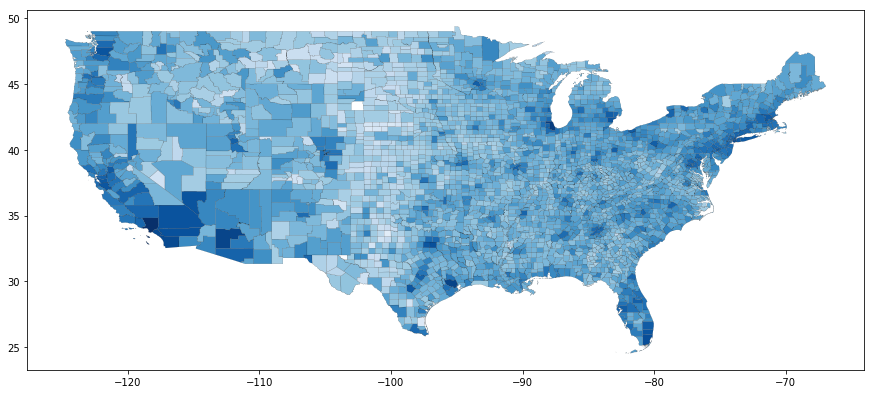

In [23]:
# Merge the GeoDataFrame df_counties with the population data
counties_choropleth = pd.merge(df_counties, df_county_population, on=['STATEFP', 'COUNTYFP'])

counties_choropleth.plot(
    figsize=(15,15), 
    column='LogPopulation', 
    cmap='Blues', # http://matplotlib.org/users/colormaps.html
    # scheme='Quantiles', # alternatives are 'Quantiles', Equal_Interval', and 'Fisher_Jenks'; Quantiles requires PySAL
    linewidth=0.1, 
    edgecolor='black')